## Deep Learning

## Generative Adversarial Networks exploration

---
## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS
import os
import csv
import math
import random
import time
import os.path as path
from datetime import datetime
import cv2
import pickle
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.learn import monitors
from tensorflow.contrib.metrics import streaming_accuracy, streaming_precision, streaming_recall

# Visualizations will be shown in the notebook.
%matplotlib inline 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


---
## Step 1: Load Datasets & Basic Exploration of Dataset

In [2]:
## LOAD PICKLED DATASET & SPLIT DATA
print("Obtaining datasets.")
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)

X_train, y_train = mnist.train.images, mnist.train.labels
X_valid, y_valid = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

print("Ensuring equal lengths for features and labels.")
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))

Obtaining datasets.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Ensuring equal lengths for features and labels.


### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
## BASIC UNDERSTANDING OF DATASET

# Number of training examples.
n_train = X_train.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an image.
image_shape = X_train[1].shape

# Unique classes/labels in the dataset.
n_classes = y_train.shape[1]

# Further manipulation.
total_sets=n_train+n_validation+n_test
frac_train=n_train/total_sets
frac_valid=n_validation/total_sets
frac_test=n_test/total_sets

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("There are",total_sets, "datasets, split",round(frac_train,2),"-",\
      round(frac_valid,2),"-",round(frac_test,2),"training, validation, and testing respectively.")
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 55000
Number of validation examples = 5000
Number of testing examples = 10000
There are 70000 datasets, split 0.79 - 0.07 - 0.14 training, validation, and testing respectively.
Image data shape = (784,)
Number of classes = 10


#### Visualizing sample training set images

Label  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


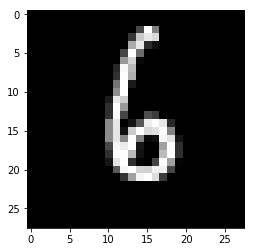

In [4]:
## DATA EXPLORATION & VISUALIZATION
index=np.random.randint(0,n_train)
image=X_train[index]
plt.imshow(np.reshape(image,(28,28)),cmap='gray')
print("Label ",y_train[index])

----

## Step 3: Design and Test a Model Architecture

### Model Architecture- Setups

In [5]:
EPOCHS=30
BATCH_SIZE=1024

# BASIC HYPERPARAMETERS
mu=0.0
sigma=0.1
# MISC
save_path='./tf-sessions-data'

In [6]:
# Defining commonly used tensorflow functions

def convolution(layer,kernel,bias):
    # W- Weight [Filter height, Filter width, color_channels, k_output]
    temp=tf.nn.conv2d(layer,kernel,strides=[1,1,1,1],padding='SAME')
    return tf.nn.bias_add(temp,bias)

def full_connected(layer,weight,bias):
    temp=tf.matmul(layer,weight)
    return tf.nn.bias_add(temp,bias)
    
def maxpool(layer):
    return tf.nn.max_pool(layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

def elu(layer,name):
    return tf.nn.elu(layer,name=name)

def dropout(layer,keep_prob):
    return tf.nn.dropout(layer,keep_prob)

def evaluate(X_dataset,Y_dataset):
    total_accuracy=0
    data_size=len(X_dataset)
    
    sess=tf.get_default_session()
    for offset in range(0,data_size,BATCH_SIZE):
        batch_x,batch_y=X_dataset[offset:offset+BATCH_SIZE],Y_dataset[offset:offset+BATCH_SIZE]
        local_accuracy=sess.run(accuracy_operation,feed_dict={X:batch_x, Y:batch_y, keep_prob:1.0})
        total_accuracy+=(local_accuracy*len(batch_x))
    return total_accuracy/data_size

In [7]:
X=tf.placeholder(tf.float32,(None,28*28))
X_image=tf.reshape(X, [-1,28,28,1])
Y= tf.placeholder(tf.float32, shape=[None, 10])
keep_prob=tf.placeholder(tf.float32)

In [8]:
sess=tf.InteractiveSession()

In [9]:
def CNN(x):
#     with tf.variable_scope("param"):
    weights={
        'W_conv1': tf.Variable(tf.truncated_normal(shape=(5,5,1,16), mean=mu, stddev=sigma), name='W_conv1'),
        'W_conv2': tf.Variable(tf.truncated_normal(shape=(3,3,16,32), mean=mu, stddev=sigma), name='W_conv2'),
        'W_conv3': tf.Variable(tf.truncated_normal(shape=(3,3,32,64), mean=mu, stddev=sigma), name='W_conv2'),
        
        'W_dense1': tf.Variable(tf.truncated_normal(shape=(1024,512), mean=mu, stddev=sigma), name='W_dense1'),
        'W_dense2': tf.Variable(tf.truncated_normal(shape=(512,256), mean=mu, stddev=sigma), name='W_dense2'),
        'W_dense3': tf.Variable(tf.truncated_normal(shape=(256,64), mean=mu, stddev=sigma), name='W_dense3'),
        'W_output': tf.Variable(tf.truncated_normal(shape=(64,10), mean=mu, stddev=sigma), name='W_output') 
    }
    
    biases={
        'b_conv1': tf.Variable(tf.truncated_normal([16])),
        'b_conv2': tf.Variable(tf.truncated_normal([32])),
        'b_conv3': tf.Variable(tf.truncated_normal([64])),
       
        'b_dense1': tf.Variable(tf.truncated_normal([512])),
        'b_dense2': tf.Variable(tf.truncated_normal([256])),
        'b_dense3': tf.Variable(tf.truncated_normal([64])),
        'b_output': tf.Variable(tf.truncated_normal([10]))
    }
    
    # Layer One: Convolution
    with tf.name_scope("Convolution_Layer_1") as scope:
        conv1=convolution(x,weights['W_conv1'],biases['b_conv1'])
        # Layer One: Activation
        conv1=elu(conv1,'activation_1')
    # Layer One: Max-Pooling
    with tf.name_scope("MaxPool_1") as scope:
        pool1=maxpool(conv1)
        
    # Layer Two: Convolution
    with tf.name_scope("Convolution_Layer_2") as scope:
        conv2=convolution(pool1,weights['W_conv2'],biases['b_conv2'])
        # Layer Two: Activation
        conv2=elu(conv2,'activation_2')
    # Layer Two: Max-Pooling
    with tf.name_scope("MaxPool_2") as scope:
        pool2=maxpool(conv2)
        
    # Layer Three: Convolution
    with tf.name_scope("Convolution_Layer_3") as scope:
        conv3=convolution(pool2,weights['W_conv3'],biases['b_conv3'])
        # Layer Two: Activation
        conv3=elu(conv3,'activation_3')
    # Layer Two: Max-Pooling
    with tf.name_scope("MaxPool_3") as scope:
        pool3=maxpool(conv3)
        
    # Flatten Layer
    with tf.name_scope("Flatten_Layer") as scope:
        flat=flatten(pool3)

    # Layer Three: Full Connected
    with tf.name_scope("Dense_Layer_1") as scope:
        dense1=full_connected(flat,weights['W_dense1'],biases['b_dense1'])
        # Layer Three: Activation
        dense1=elu(dense1,'activation_4')
    # Layer Three: Dropout
    with tf.name_scope("Dropout_1") as scope:
        dense1_dropout=dropout(dense1,keep_prob)

    # Layer Four: Full Connected
    with tf.name_scope("Dense_Layer_2") as scope:
        dense2=full_connected(dense1_dropout,weights['W_dense2'],biases['b_dense2'])
        # Layer Four: Activation
        dense2=elu(dense2,'activation_5')
    # Layer Four: Dropout
    with tf.name_scope("Dropout_2") as scope:
        dense2_dropout=dropout(dense2,keep_prob)

    # Layer Five: Full Connected
    with tf.name_scope("Dense_Layer_3") as scope:
        dense3=full_connected(dense2_dropout,weights['W_dense3'],biases['b_dense3'])
        # Layer Five: Activation
        dense3=elu(dense3,'activation_6')
     
    # Layer Six: Full Connected
    with tf.name_scope("Output_Layer") as scope:
        logits=full_connected(dense3,weights['W_output'],biases['b_output'])

    return logits 

#### Train, Validate and Test the Model:Simple convolutoin network architecture

In [10]:
with tf.name_scope("EntropyCost") as scope:
    logits_cnn=CNN(X_image)
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=logits_cnn)
    loss=tf.reduce_mean(cross_entropy)
    
# L-2 Regularization
penalty_term=1e-6

vars=tf.trainable_variables()
l2_loss_term=tf.add_n([tf.nn.l2_loss(var) for var in vars if 'W_' in var.name])
loss_operation=(loss+penalty_term*l2_loss_term)
    
optimizer=tf.train.AdamOptimizer()
training_operation=optimizer.minimize(loss_operation)

In [11]:
with tf.name_scope("Evaluate") as scope:
    correct_prediction=tf.equal(tf.argmax(logits_cnn,1),tf.argmax(Y,1))
    accuracy_operation=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    accuracy_summary=tf.summary.scalar("accuracy",accuracy_operation)
    saver=tf.train.Saver()

In [12]:
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    data_size=len(X_train)
    
    print("Convolution Neural Network Training in progress...")
    print()
    CNNarchitecture_start=time.clock()
    
    # Logging data
    Epochs=[]
    Training_losses=[]
    Training_accuracies=[]
    Validation_accuracies=[]
    
    for i in range(EPOCHS):
        Epoch_time=time.clock()
       
        
        for offset in range(0,data_size,BATCH_SIZE):
            end=offset+BATCH_SIZE
            batch_x,batch_y=X_train[offset:end],y_train[offset:end]
            _,l=sess.run([training_operation, loss], feed_dict={X:batch_x, Y:batch_y, keep_prob:0.50})
        
        training_accuracy=evaluate(X_train,y_train)
        validation_accuracy=evaluate(X_valid,y_valid)
        
        print("EPOCH {} with forward-backward propagation time of {}s".format(i+1,round(time.clock()-Epoch_time,3)))
        print("Learning Rate of {:.8f}".format(sess.run(optimizer._lr_t)))
        print("Training batch loss at Epoch {}: {:.5f}".format(i+1, l))
        print("Training Accuracy of {:.5f}".format(training_accuracy))
        print("Validation Accuracy of {:.5f}".format(validation_accuracy))
        print()
        
        # Logging data
        Epochs.append(i)
        Training_losses.append(l)
        Training_accuracies.append(training_accuracy)
        Validation_accuracies.append(validation_accuracy) 
    
    CNNarchitecture_end=time.clock()    
    saver.save(sess,save_path)
    print("Simplfied CNN architecture Train-Test time {}s.".format(round((CNNarchitecture_end-CNNarchitecture_start),2)))
    print("Simplified CNN model trained and saved.")

Convolution Neural Network Training in progress...

EPOCH 1 with forward-backward propagation time of 3.814s
Learning Rate of 0.00100000
Training batch loss at Epoch 1: 0.77579
Training Accuracy of 0.82333
Validation Accuracy of 0.83640

EPOCH 2 with forward-backward propagation time of 2.769s
Learning Rate of 0.00100000
Training batch loss at Epoch 2: 0.32974
Training Accuracy of 0.93904
Validation Accuracy of 0.94440

EPOCH 3 with forward-backward propagation time of 2.76s
Learning Rate of 0.00100000
Training batch loss at Epoch 3: 0.22872
Training Accuracy of 0.96125
Validation Accuracy of 0.96480

EPOCH 4 with forward-backward propagation time of 2.772s
Learning Rate of 0.00100000
Training batch loss at Epoch 4: 0.18509
Training Accuracy of 0.97022
Validation Accuracy of 0.97180

EPOCH 5 with forward-backward propagation time of 2.805s
Learning Rate of 0.00100000
Training batch loss at Epoch 5: 0.14276
Training Accuracy of 0.97458
Validation Accuracy of 0.97480

EPOCH 6 with forwar

## Chosen Model Evaluation

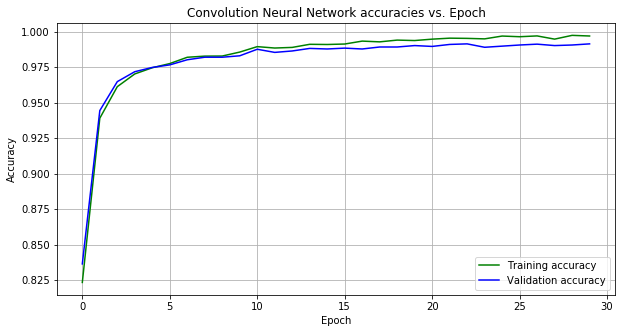

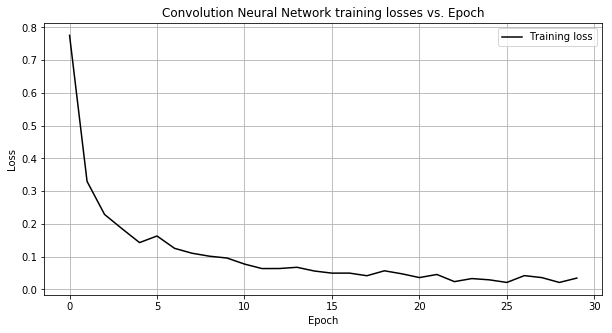

In [13]:
plt.figure(figsize=(10,5))
plt.plot(Epochs,Training_accuracies,'green', label='Training accuracy')
plt.plot(Epochs,Validation_accuracies,'blue', label='Validation accuracy')
plt.title("Convolution Neural Network accuracies vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
         
plt.figure(figsize=(10,5))
plt.plot(Epochs,Training_losses,'black', label='Training loss')
plt.title("Convolution Neural Network training losses vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [14]:
meta_path='./tf-sessions-data.meta'
data_path='./tf-sessions-data.data-00000-of-00001'
index_path='./tf-sessions-data.index'
save_path='./tf-sessions-data'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # saver=tf.train.import_meta_graph(meta_path)
    saver.restore(sess,save_path)
    test_accuracy=evaluate(X_test,y_test)
    
print("No further training or tuning of hyperparameters!")
print("Testing dataset has an accuracy of {} %".format(round(test_accuracy*100),2))

INFO:tensorflow:Restoring parameters from ./tf-sessions-data
No further training or tuning of hyperparameters!
Testing dataset has an accuracy of 99.0 %


---

## Step 4: GANs implementation

### Predict the Sign Type for an adversarial Image using a specific CNN

In [15]:
def CNN_evaluate(new_images,sess):
    prediction=sess.run(tf.argmax(logits_cnn,1), feed_dict={X: new_images, keep_prob: 1.0})
    top_k=tf.nn.top_k(tf.nn.softmax(logits_cnn),10, sorted=True)
    top_k_pred=sess.run(top_k, feed_dict={X: new_images, keep_prob:1.0})
    return prediction, top_k_pred

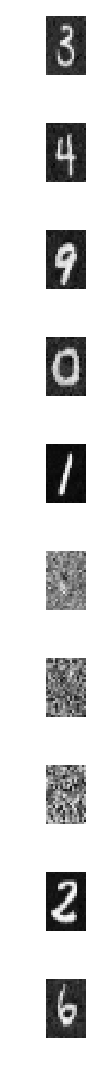

In [16]:
save_folder='output_images/'
valid_choice=[]

n_redo=0

if len(os.listdir(save_folder))>1 and n_redo==0:
    items=os.listdir(save_folder)
    images_list=np.zeros((12,32,32,3),dtype=np.uint8)
    
    for name in items:
        if name.endswith(".png"):
            valid_choice.append(name)
    for i, item in enumerate(valid_choice):
        image=cv2.resize(cv2.imread(os.path.join(save_folder,item)),(32,32))
        images_list[i]=image
    # Plot, Subplots
    plt.figure(figsize=(15,15))
    for num_images in range(10):
        plt.subplot(10,1,num_images+1)
        plt.tight_layout()
        plt.imshow(images_list[num_images])
        plt.axis('off')
    plt.show()    

In [17]:
def grayscale(raw_image): # Convert to grayscale
    return cv2.cvtColor(raw_image,cv2.COLOR_BGR2GRAY)

In [18]:
## Preprocessing new images
adversarial_images=[]

for image in images_list:
    image_reshaped=grayscale(image)[2:-2,2:-2].reshape(28*28)
    adversarial_images.append((image_reshaped))
print("Preprocessing Test images complete")

Preprocessing Test images complete


In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)

    predicted_label,top_k=CNN_evaluate(np.asarray(adversarial_images),sess) 

INFO:tensorflow:Restoring parameters from ./tf-sessions-data


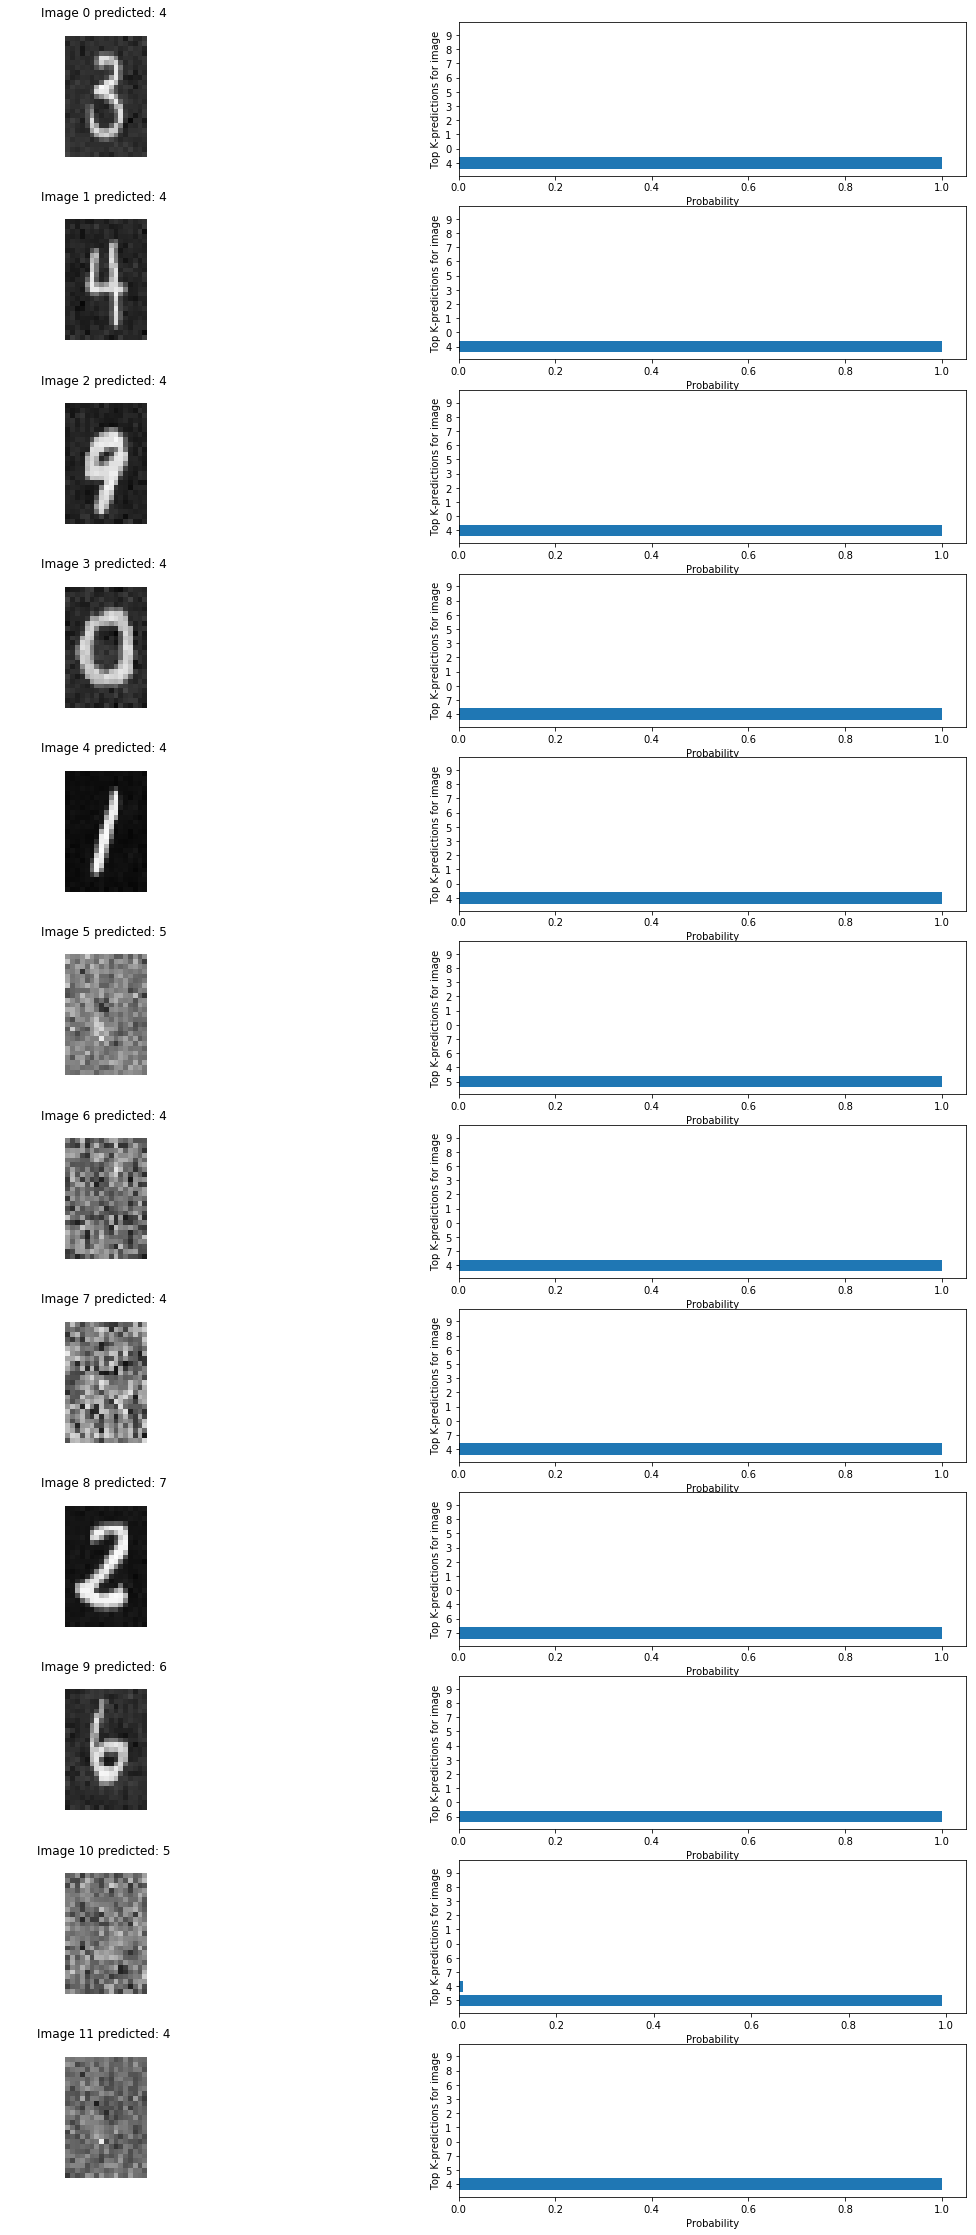

In [20]:
plt.figure(figsize=(20,40))
for i in range(len(adversarial_images)):
    plt.subplot(len(adversarial_images),2,2*i+1)
    plt.imshow(images_list[i])
    plt.axis('off')
    plt.title("Image "+str(i)+" predicted: "+str(predicted_label[i]))
    
    plt.subplot(len(adversarial_images),2,2*i+2)
    plt.barh(np.arange(1,11,1),top_k.values[i,:])
    plt.yticks(np.arange(1,11,1),(ind for ind in top_k.indices[i]))
    
    plt.xlabel('Probability')
    plt.ylabel('Top K-predictions for image')
plt.show()    

In [21]:
print(predicted_label)

[4 4 4 4 4 5 4 4 7 6 5 4]


In [22]:
print(top_k)

TopKV2(values=array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.9184689e-32, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.4602730e-09, 2.6316599e-12, 1.7871922e-24,
        0.0000000e+00, 0.0000000e+00, 0.000

---

## Step 5: Visualize the Neural network feature maps for adversarial images

In [23]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={X : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

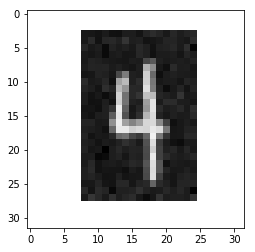

In [24]:
# Selecting a random image from the validation dataset.
item='Targeted_4.png'
image=cv2.resize(cv2.imread(os.path.join(save_folder,item)),(32,32))
selected_image=grayscale(image)[2:-2,2:-2].reshape(1,28*28)

plt.imshow(grayscale(image).reshape(32,32), cmap='gray')
plt.show()

In [25]:
# Listing paths in the graph
# save_path='./tf-sessions-data/'

activation_1="EntropyCost/Convolution_Layer_1/activation_1:0"
activation_2="EntropyCost/Convolution_Layer_2/activation_2:0"
activation_3="EntropyCost/Convolution_Layer_3/activation_3:0"
activation_4="EntropyCost/Dense_Layer_1/activation_4:0"
activation_5="EntropyCost/Dense_Layer_2/activation_5:0"
activation_6="EntropyCost/Dense_Layer_3/activation_6:0"

Layer One Activation
INFO:tensorflow:Restoring parameters from ./tf-sessions-data


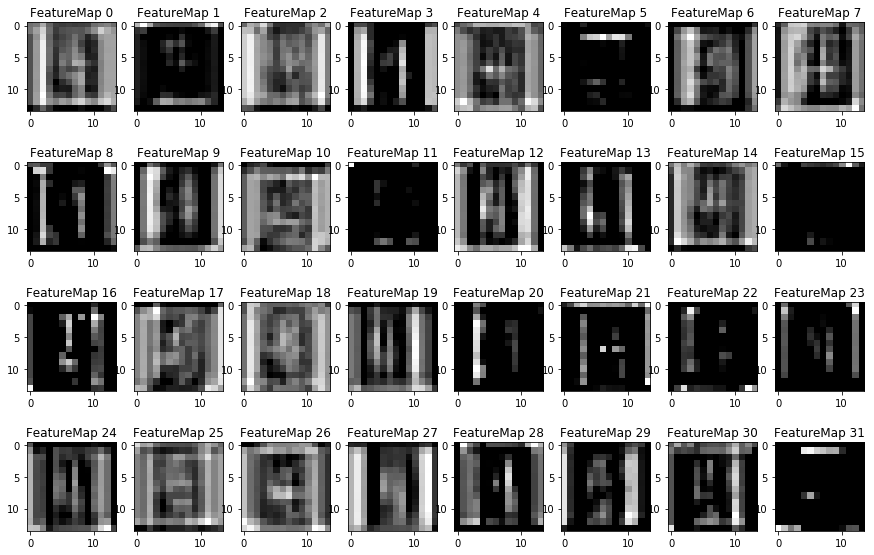

In [26]:
print("Layer One Activation")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)
       
    act1=tf.get_default_graph().get_tensor_by_name(activation_1)
    act2=tf.get_default_graph().get_tensor_by_name(activation_2)
    outputFeatureMap(selected_image,act1)
    outputFeatureMap(selected_image,act2)

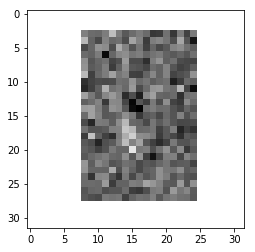

In [27]:
# Selecting a random image from the validation dataset.
item='Nontargeted_8.png'
image=cv2.resize(cv2.imread(os.path.join(save_folder,item)),(32,32))
selected_image=grayscale(image)[2:-2,2:-2].reshape(1,28*28)

plt.imshow(grayscale(image).reshape(32,32), cmap='gray')
plt.show()

Layer One Activation
INFO:tensorflow:Restoring parameters from ./tf-sessions-data


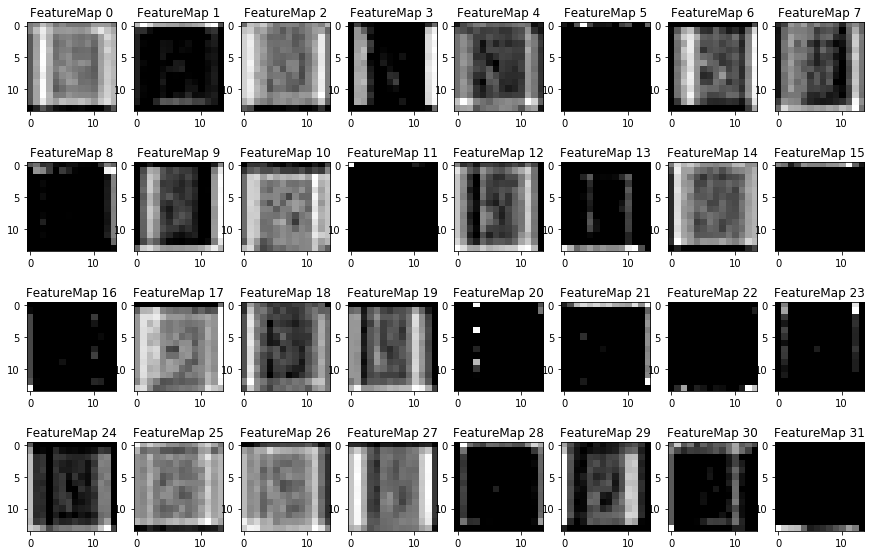

In [28]:
print("Layer One Activation")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)
    
    act1=tf.get_default_graph().get_tensor_by_name(activation_1)
    act2=tf.get_default_graph().get_tensor_by_name(activation_2)
    outputFeatureMap(selected_image,act1)
    outputFeatureMap(selected_image,act2)

In [ ]:
sess.close()

In [ ]:
print("Script terminated at",str(datetime.now()))